### AIDI 1002 - AI Algorithms - Final Project

### Sentiment Analysis

Michael Molnar - Durham College #100806823

## Notebook 1:  Exploratory Data Analysis

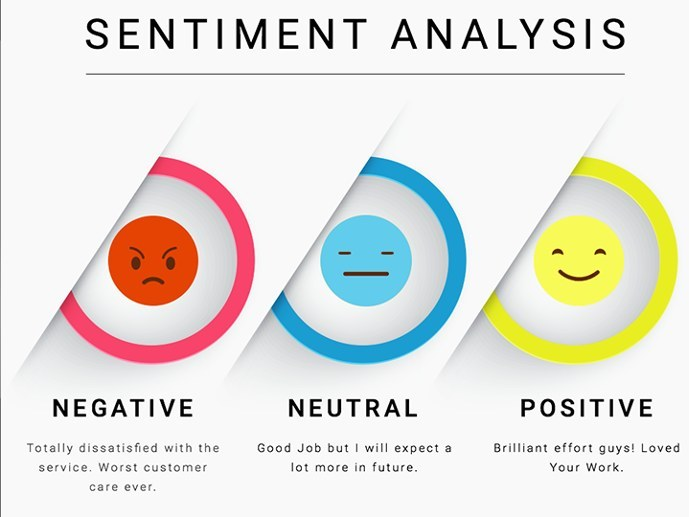

In [8]:
from IPython.display import Image
Image(filename = 'sentiment_img.jpg')

(Image Source: https://www.kdnuggets.com/2018/03/5-things-sentiment-analysis-classification.html)

#### Problem Statement:

How can we use machine learning to automatically extract the sentiment of every review, comment, blog post, or news article that mentions your business or your products?  

This project will create a model that will automatically analyze text and predict its sentiment - negative, neutral, or positive.  This solution will allow a business to automatically parse reviews and comments it receives, sorting them, and allowing for the analyis of how customers feel about the business and brand.  This analysis will allow for a company to determine how feelings towards the company change over time, or after the release of a new product or a shift in direction.  Unhappy customers can be automatically identified and prioritized.  

The proposed solution will be a classification model trained on real product reviews to identify the key words and phrases that most accurately predict the sentiment of a sample of text.

#### Focus of Notebook 1:

In this notebook I will acquire and explore the dataset.  I will first identify and deal wtih any missing data.  Next, I will explore the distribution of the ratings.  Then I will take an indepth look into the review text that will be the focus of my machine learning solution.  I will explore the nature of the text and identify issues that must be addressed as part of the data cleaning and feature engineering stage that will be the focus of the next notebook.

#### Data Source:

For this project I will be creating a model trained on the Amazon Review Data (2018) resource.  This is a collection of 233.1 million Amazon product reviews, grouped by product type, and maintained by Jianmo Ni.  I have elected to work with the Arts, Crafts, and Sewing subset of the data.  This provides me with 494,485 customer reviews.

#### Dataset Source:

Ni J. Amazon Review Data (2018). https://nijianmo.github.io/amazon/index.html.

#### Citation Required for Use:

Ni J, Li J, McAuley J. Justifying Recommendations using Distantly-Labeled Reviews and Fine-Grained Aspects. Empirical Methods in Natural Language Processing (EMNLP). 2019. http://cseweb.ucsd.edu/~jmcauley/pdfs/emnlp19a.pdf.


### Import Necessary Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

### Loading the Data

In [2]:
# Save into a Panda's DataFrame
df = pd.read_json('Arts_Crafts_and_Sewing_5.json.gz', orient='records', lines=True)
df.shape

(494485, 12)

In [3]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,True,"03 29, 2016",AIE8N9U317ZBM,0449819906,{'Format:': ' Kindle Edition'},"Zelmira, Ph.D.",Contains some interesting stitches.,Four Stars,1459209600,NaN,NaN
1,5,True,"08 12, 2015",A3ECOW0TWLH9V6,0449819906,{'Format:': ' Paperback'},Dangerous when Cooking,I'm a fairly experienced knitter of the one-co...,My current favorite go-to guide for inspiration,1439337600,18,NaN
2,4,True,"04 5, 2015",A278N8QX9TY2OS,0449819906,{'Format:': ' Paperback'},Just us,Great book but the index is terrible. Had to w...,"lots of great examples, good instructions, col...",1428192000,3,NaN
3,5,True,"10 11, 2014",A123W8HIK76XCN,0449819906,{'Format:': ' Kindle Edition'},Amazon Customer,I purchased the Kindle edition which is incred...,Another little gem by Melissa Leapman,1412985600,NaN,NaN
4,5,True,"05 8, 2014",A2A6MZ2QB4AE0L,0449819906,{'Format:': ' Paperback'},Sustainability,Very well laid out and very easy to read.\n\nT...,Very comprehensive,1399507200,NaN,NaN


The focus of this project will be on predicting sentiment by text analysis.  For this reason I will remove all columns except for the rating, "overall", and actual text, "reviewText".

### Exploratory Data Analysis

In [4]:
# Drop unnecessary columns
df.drop(columns=['verified', 'reviewTime', 'reviewerID', 'asin', 'style', 'reviewerName', 'unixReviewTime', 
                 'vote', 'image', 'summary'], inplace=True)

In [5]:
# Check for missing values
df.isna().sum()

overall         0
reviewText    289
dtype: int64

289 of the 494,485 reviews do not contain text and will be removed.

In [9]:
# Drop rows where there is no text
df.dropna(inplace=True)

In [18]:
# Confirm there are no missing values
df.isna().sum()

overall       0
reviewText    0
num words     0
dtype: int64

In [19]:
# Check the types of the data 
df.dtypes

overall        int64
reviewText    object
num words      int64
dtype: object

In [20]:
# Recheck the size of the data
df.shape

(494196, 3)

### Examining the Ratings

In [21]:
# Get the rating counts
df['overall'].value_counts()

5    377313
4     61127
3     28622
1     14353
2     12781
Name: overall, dtype: int64

Text(0.5, 1.0, 'Distribution of Ratings')

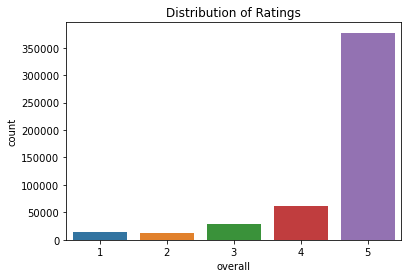

In [22]:
# Plot as a bar plot 
sns.countplot(x='overall', data=df).set_title('Distribution of Ratings')

In [23]:
# Get the percentages of each label
percentages = pd.Series(df['overall'].value_counts()/len(df.index)*100)
percentages.sort_index(inplace=True, ascending=False)
percentages

5    76.348858
4    12.368979
3     5.791629
2     2.586221
1     2.904313
Name: overall, dtype: float64

There is a large imbalance present in the distribution of the ratings.  Over 76% are five out of five ratings while only 2.9% are one out of five.  This imbalance was noted in my Statement of Work document and must be dealth with.  To resolve this I will downsample the marjority class after splitting the data into training and testing sets before fitting the learning algorithms.  

### Examining the Review Text

I will create a new column, counting the number of words that appear in each review. 

In [24]:
# For each row, split the review into words and get the count
df['num words'] = df['reviewText'].apply(lambda x: len(str(x).split()))

In [30]:
# Get the summary statistics
df['num words'].describe()

count    494196.000000
mean         30.978948
std          55.670248
min           0.000000
25%           5.000000
50%          15.000000
75%          35.000000
max        3739.000000
Name: num words, dtype: float64

We see that the average review is about 31 words long.  The shortest reviews contain 0 words and the longest review is 3,739 words long.  Since I removed empty rows I will see what these zero word reviews are.

In [36]:
df[df['num words']==0]

,overall,reviewText,num words
172146,5,,0
312399,5,,0


In [38]:
df['reviewText'][172146]

' '

In [39]:
df['reviewText'][312399]

'  '

These two rows are just empty strings.  In the next notebook I will be removing punctions, stop words, etc.  Some reviews will be made into empty strings by this proccess - for example, "A+" - and so all of these empty strings will be removed at the end.

Next I will examine the reviews that are one word in length.

In [40]:
df[df['num words'] == 1]

,overall,reviewText,num words
34,5,Nice,1
63,4,gift,1
64,5,ok,1
89,4,Good,1
112,5,gift,1
...,...,...,...
494403,5,PERFECT!,1
494422,5,Good,1
494429,5,Beautiful,1
494436,5,good,1


There are over 27,000 one word reviews.  What is good to note here from this sample is that the word seems reflective of the rating - beautiful, excellent, perfect - are examples of five out of five ratings.  This sample shows only four or five out of five reviews, so next I will look at the case when the rating is one.

In [41]:
df[(df['num words'] == 1) & (df['overall'] == 1)]

,overall,reviewText,num words
5134,1,Yarn,1
10513,1,NOTHIN,1
11136,1,Ripoff,1
13227,1,Whatever,1
14367,1,ok,1
...,...,...,...
474397,1,Worthless.,1
480377,1,Junk,1
484340,1,Cheap,1
485594,1,cheesy,1


Again, these words are very indicative of a negative review.  Ripoff, worthless, junk, and cheap.  Interestingly someone has commented "Perfect" and then rated a product one star.

#### Ratings by Review Length

I will examine the relationship between the length of the review and the overall rating.

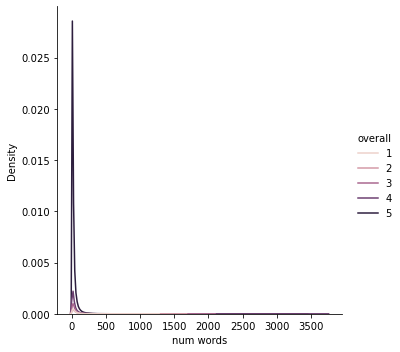

In [42]:
# Plot as a density plot 
sns.displot(df, x="num words", hue="overall", kind="kde")

Not much can be determined from this plot except that the majority of reviews are relatively short in lenght.  Next I will filter for fives less than 100 words and see this distribution once again.

In [43]:
df_short = df[df['num words'] < 100]

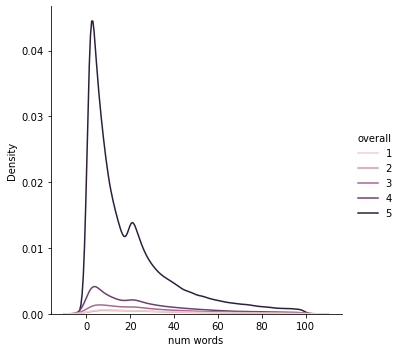

In [44]:
sns.displot(df_short, x="num words", hue="overall", kind='kde')

Looking at a plot of all reviews 100 words or less, we can see that very short reviews are most common for all ratings.

When it comes time to create the model I will be dividing the ratings into three sentiments - 4 and 5 will be positive, 3 will be neutral, and 1 and 2 will be negative.  For the purposes of the following analysis I will create three subsets - the 5/5 reviews, the 3/5 reviews, and the 1/5 reviews, to get a sense of how the text varies according to the three sentiments.

In [45]:
# Filter the dataframe into three new dataframes 
df_five = df[df['overall']==5]
df_three = df[df['overall']==3]
df_one = df[df['overall']==1]

In [49]:
# Get the summary statistics for 5/5 reviews 
print("Five Star Review Lengths:")
print("Shortest:", df_five['num words'].min())
print("Longest:", df_five['num words'].max())
print("Average:", df_five['num words'].mean())

Five Star Review Lengths:
Shortest: 0
Longest: 3445
Average: 26.96077262113948


In [50]:
# Get the summary statistics for 3/5 reviews 
print("Three Star Review Lengths:")
print("Shortest:", df_three['num words'].min())
print("Longest:", df_three['num words'].max())
print("Average:", df_three['num words'].mean())

Three Star Review Lengths:
Shortest: 1
Longest: 2070
Average: 45.28271958633219


In [51]:
# Get the summary statistics for 1/5 reviews 
print("One Star Review Lengths:")
print("Shortest:", df_one['num words'].min())
print("Longest:", df_one['num words'].max())
print("Average:", df_one['num words'].mean())

One Star Review Lengths:
Shortest: 1
Longest: 1250
Average: 48.056364523096214


We see that the average review length increases as the rating decreases.  This would have been my expectation.  A person who is very displeased with a product will probably take the time to vent frustrations and alert others to their negative experience.  

### Examining the Most Common Words

To perform these next tasks I will make use of Sckit Learn's Count Vectorizer.
(https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

I will fit and transform the reviews into individual words (unigrams) first, and then word pairs (bigrams).  Doing this will allow me to generate the number of times each word or word pair appears in the entire collection of reviews, and from there generate a list of the most commonly appearing ones. 

In [53]:
"""
This function will take a corups of documents, a length, and an n as parameters.
It will use the Count Vectorizer to create a list of words (word combinations if a 
length is provided) and count the number of times each appears in the corpus.  It will 
then sort by count and return the top n, requested.
"""
def n_most_common (corpus, length=1, n=None):
   # Create a Count Vectorizer object and fit and transform the corpus
    vec = CountVectorizer(ngram_range=(length, length)).fit(corpus)
    words = vec.transform(corpus)
    
    # This creates a matrix with a row for each row of the dataset 
    # The columns represent each unique word in the corpus, with values for the 
    # count within that row. 
    # Summing along each column will produce the count for each unique word
    # Sum the occurrence of each uniqe word
    sum_words = words.sum(axis=0) 
        
    # vec.vocabulary_ is a dictionary of words and their indexes 
    # create tuples for each word and the sum according to its index in sum_words
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    # Sort in descending order by value, the count
    words_freq =sorted(words_freq, key = lambda item: item[1], reverse=True)
    
    # Return the words and counts of the n highest
    return words_freq[:n]

In [54]:
# Get the 30 most common words in the entire collection
n_most_common(df['reviewText'], n=30)

[('the', 639532),
 ('and', 436263),
 ('to', 411884),
 ('it', 367319),
 ('for', 267572),
 ('this', 229140),
 ('of', 225935),
 ('is', 207996),
 ('my', 165893),
 ('with', 157303),
 ('in', 143570),
 ('are', 135659),
 ('great', 130746),
 ('you', 128913),
 ('that', 128171),
 ('on', 122049),
 ('have', 121610),
 ('but', 117997),
 ('these', 113370),
 ('they', 109215),
 ('as', 102039),
 ('not', 101392),
 ('so', 100712),
 ('use', 97957),
 ('very', 97677),
 ('was', 92296),
 ('love', 85226),
 ('them', 80859),
 ('good', 72304),
 ('be', 68406)]

We see that these are all very common words.  The removal of these "stop words" will be part of engineering the text in the next notebook.  Before that is done I will expand contractions, remove punctuations, and perform other necessary cleaning.  For now, I will use the Count Vectorizer's built in stop words parameter to continue this analysis.

In [55]:
# The same function as above but adding the stop words parameter to the Count Vectorizer
def n_most_common_no_stop (corpus, length=1, n=None):
    vec = CountVectorizer(ngram_range=(length, length), stop_words='english').fit(corpus)
    words = vec.transform(corpus)
    sum_words = words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [56]:
# Get the 30 most common non-stop words
n_most_common_no_stop(df['reviewText'], n=30)

[('great', 130746),
 ('use', 97957),
 ('love', 85226),
 ('good', 72304),
 ('just', 64467),
 ('like', 61529),
 ('nice', 53092),
 ('product', 52962),
 ('used', 45083),
 ('work', 44219),
 ('quality', 41872),
 ('colors', 40228),
 ('easy', 39889),
 ('really', 38894),
 ('color', 38109),
 ('price', 37907),
 ('make', 36725),
 ('works', 36502),
 ('perfect', 35422),
 ('paper', 34214),
 ('time', 34033),
 ('little', 33858),
 ('set', 31493),
 ('using', 30978),
 ('machine', 30107),
 ('don', 28662),
 ('yarn', 28553),
 ('size', 27170),
 ('buy', 25397),
 ('bought', 24980)]

There are some interesting things here.  Since five star reviews make up the majority of the data, words such as great, good, love, quality, nice, and easy are among the most commonly appearing non-stop words.  Since the reviews are for art supplies, color, colors, and paper are also among the most common.  I note the word "don".  As part of the next notebook I will be expanding contractions - don't into do not, for example - before removing stop words.  I also note that the word "not" has been removed.  This will be the type of word I will want to keep and will remove from the stop words list, since this is a word that is related to sentiment in phrases such as "not good", for example.  Simply removing "not" and leaving "good" would completely change the meaning of the phrase.

I will now use the same function to generate the most common words according to the different ratings.

#### Five Stars

In [57]:
# Most common words in five star ratings
five_star_words = n_most_common_no_stop(df_five['reviewText'], n=30)

# Convert to dictionary for plotting as a word cloud
five_star_words = dict(five_star_words)

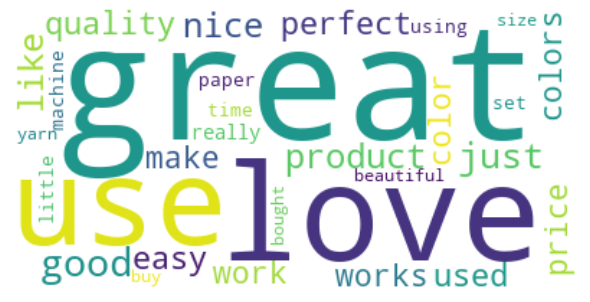

In [58]:
# Plot the word cloud
# Generate the size according to the dictionary values
cloud = WordCloud(background_color='white').generate_from_frequencies(five_star_words)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

We see some clearly positive words here - great, love, quality, nice, good, easy, perfect.

#### Three Stars

In [59]:
# Most common words in three star ratings
three_star_words = n_most_common_no_stop(df_three['reviewText'], n=30)
# Convert to dictionary for plotting as a word cloud
three_star_words = dict(three_star_words)

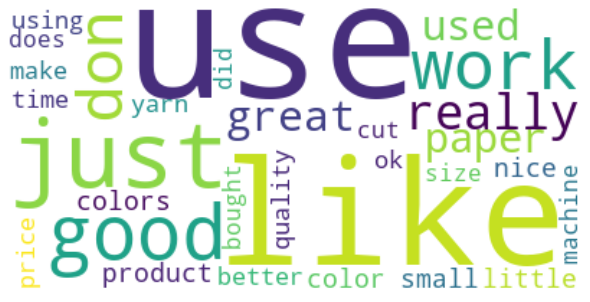

In [60]:
cloud2 = WordCloud(background_color='white').generate_from_frequencies(three_star_words)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(cloud2, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

With three star reviews we see some words that would represent a neutral sentiment - good, like, and ok, for example.  There are words such as really, just, and little, which could have more meaning when combined with the other words in the sentences.  This will be explored next in the bigrams section.

#### One Star

In [61]:
# Most common words in one star ratings
one_star_words = n_most_common_no_stop(df_one['reviewText'], n=30)
# Convert to dictionary for plotting as a word cloud
one_star_words = dict(one_star_words)

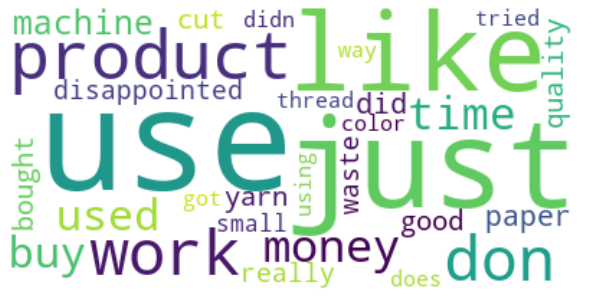

In [62]:
cloud3 = WordCloud(background_color='white').generate_from_frequencies(one_star_words)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(cloud3, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

There are a couple of negative words here - disappointed and waste.  There are words like quality and like, which would represented more positive sentiments on their own.  It is for this reason that I will be exploring word combinations next.  If the phrase was "poor quality", for example, the sentiment would be in line with a negative rating.

### Examing Most Common Word Combinations (Bigrams)

I can reuse the function above, but adding length=2 to generate the list of the most common bigrams.  I will again do this for each of the three classes.

#### Five Stars 

In [63]:
# Get the top 30 bigrams, keeping stop words
five_star_bigrams = n_most_common(df_five['reviewText'], length = 2, n=30)
five_star_bigrams = dict(five_star_bigrams)

In [64]:
# Get the top 30 bigrams, removing stop words
five_star_bigrams_no_stop = n_most_common_no_stop(df_five['reviewText'], length = 2, n=30)
five_star_bigrams_no_stop = dict(five_star_bigrams_no_stop)

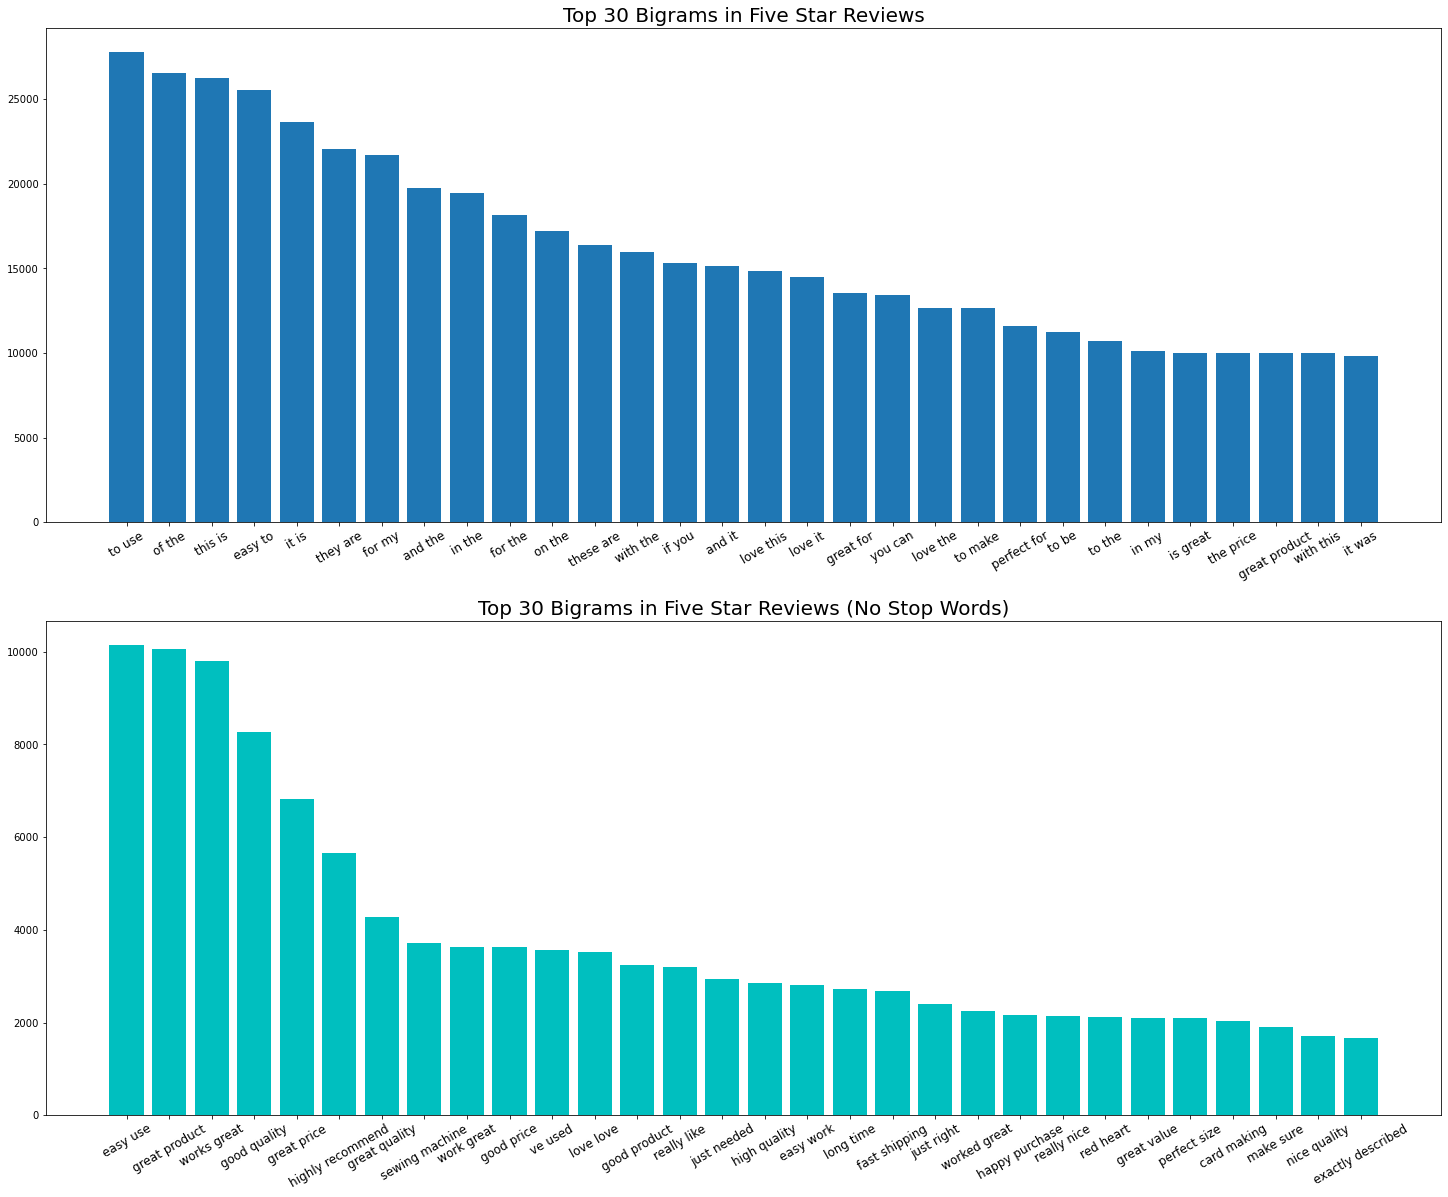

In [65]:
# Plot these two dictionaries as bar plots
fig = plt.figure(figsize=(25,20))
ax = fig.add_subplot(211)
ax.bar(five_star_bigrams.keys(), five_star_bigrams.values())
plt.xticks(rotation=30,fontsize=12)
plt.title("Top 30 Bigrams in Five Star Reviews",fontsize=20)


ax = fig.add_subplot(212)
ax.bar(five_star_bigrams_no_stop.keys(), five_star_bigrams_no_stop.values(), color='c')
plt.xticks(rotation=30,fontsize=12)
plt.title("Top 30 Bigrams in Five Star Reviews (No Stop Words)",fontsize=20)

plt.show()

As before, including stop words reveals a lot of the most common bigrams will not be predictive of the sentiment.  With these removed we can see that the most common bigrams are very helpful - "easy use", "great product", "works great", "good quality", "highly recommended", etc.

#### Three Stars

In [66]:
# Get the top 30 bigrams, keeping stop words
three_star_bigrams = n_most_common(df_three['reviewText'], length = 2, n=30)
three_star_bigrams = dict(three_star_bigrams)

In [67]:
# Get the top 30 bigrams, removing stop words
three_star_bigrams_no_stop = n_most_common_no_stop(df_three['reviewText'], length = 2, n=30)
three_star_bigrams_no_stop = dict(three_star_bigrams_no_stop)

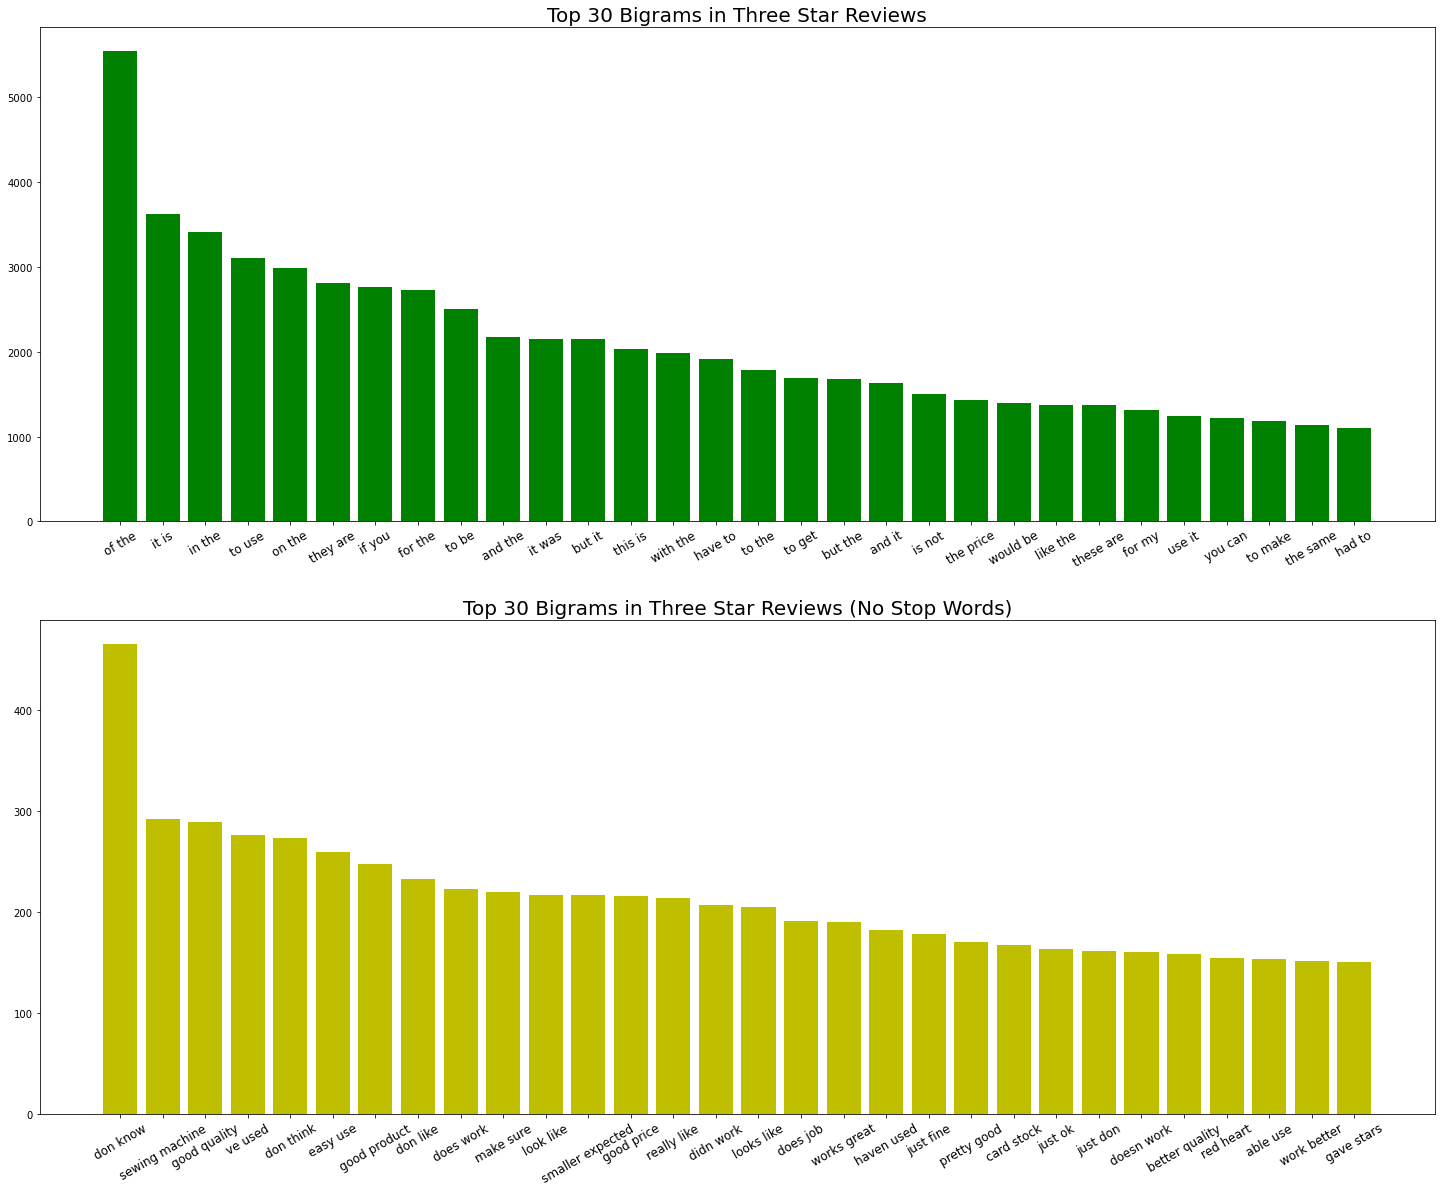

In [68]:
fig = plt.figure(figsize=(25,20))
ax = fig.add_subplot(211)
ax.bar(three_star_bigrams.keys(), three_star_bigrams.values(), color='g')
plt.xticks(rotation=30,fontsize=12)
plt.title("Top 30 Bigrams in Three Star Reviews",fontsize=20)


ax = fig.add_subplot(212)
ax.bar(three_star_bigrams_no_stop.keys(), three_star_bigrams_no_stop.values(), color='y')
plt.xticks(rotation=30,fontsize=12)
plt.title("Top 30 Bigrams in Three Star Reviews (No Stop Words)",fontsize=20)

plt.show()

There are some phrases in here that would be considered neutral sentiment.  "Don't know", "good product", "does job", "just ok".  Unlike with the five star reviews, there is a more even distribution of these 30 most common phrases.  Once it comes to modelling the impact of this on the ability to classify neutral sentiments will be determined.

#### One Star:

In [69]:
# Get the top 30 bigrams, keeping stop words
one_star_bigrams = n_most_common(df_one['reviewText'], length = 2, n=30)
one_star_bigrams = dict(one_star_bigrams)

In [71]:
# Get the top 30 bigrams, removing stop words
one_star_bigrams_no_stop = n_most_common_no_stop(df_one['reviewText'], length = 2, n=30)
one_star_bigrams_no_stop = dict(one_star_bigrams_no_stop)

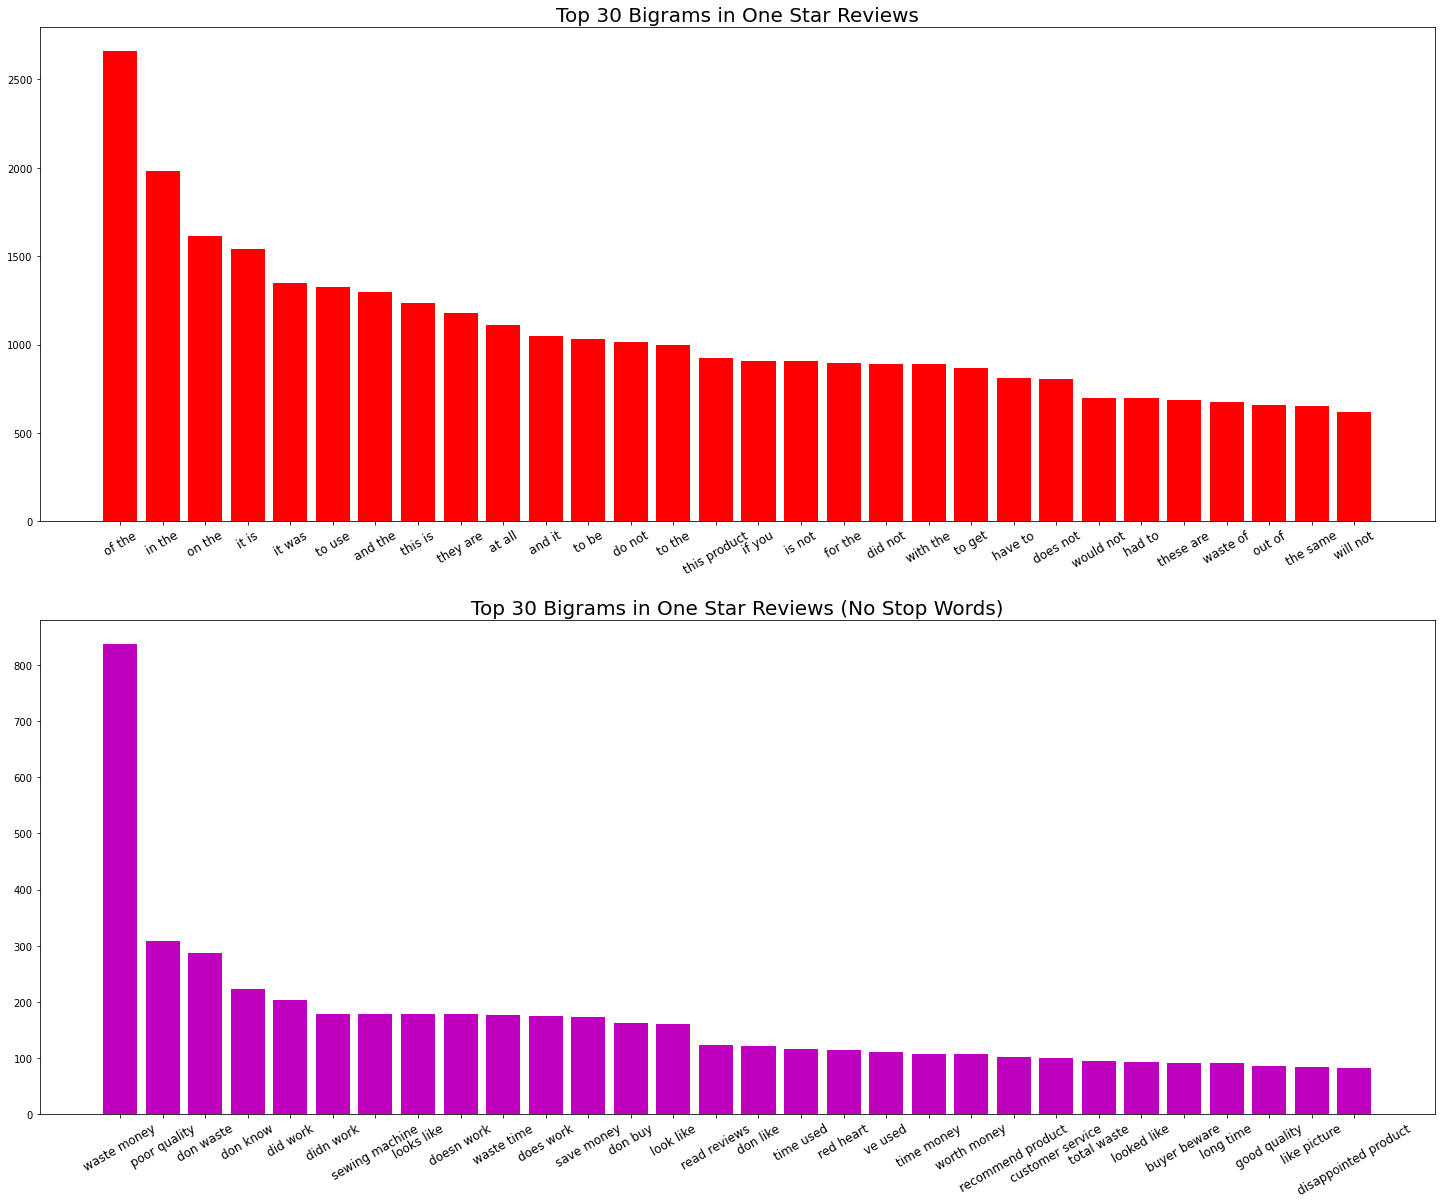

In [72]:
fig = plt.figure(figsize=(25,20))
ax = fig.add_subplot(211)
ax.bar(one_star_bigrams.keys(), one_star_bigrams.values(), color='r')
plt.xticks(rotation=30,fontsize=12)
plt.title("Top 30 Bigrams in One Star Reviews",fontsize=20)


ax = fig.add_subplot(212)
ax.bar(one_star_bigrams_no_stop.keys(), one_star_bigrams_no_stop.values(), color='m')
plt.xticks(rotation=30,fontsize=12)
plt.title("Top 30 Bigrams in One Star Reviews (No Stop Words)",fontsize=20)

plt.show()

From the previous analysis following the word cloud, here we see a lot more phrases that are clearly negative.  "Waste money", "poor quality",  "don't buy", "doesn't work", "buyer beware", and others.  

#### Preliminary Analysis

Judging by the bar plots and word clouds, the data requires a lot of cleaning and manipulation prior to modelling.  This will include:

- Expanding all contractions 
- Removing punctuation 
- Lower casing all text
- Removing special characters (such as line breaks)
- Removing stop words (customizing the list to fit the task)
- Stemming (reducing words to their root forms)

Once the text is cleaned, I will group the data into three classes - positive, neutral, and negative.  Because of the observed imbalance in the classes, I will be performing undersampling on the majority class in order to even out the distribution.  

### Next Step

Feature Engineering (Data Cleaning and Preparation) - Notebook 2